##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/saeta/Just", from: "0.7.2")' Just

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/saeta/Just", from: "0.7.2")
		Just
With SwiftPM flags: []
Working in: /tmp/tmpk_1jotca/swift-install
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/saeta/Just
Completed resolution in 1.51s
Cloning https://github.com/saeta/Just
Resolving https://github.com/saeta/Just at 0.7.3
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.3
[1/11] Compiling Path Extensions.swift
[2/11] Compiling Path Path+Attributes.swift
[3/11] Compiling Path Path+Codable.swift
[4/11] Compiling Path Path+CommonDirectories.swift
[5/11] Compiling Path Path+FileManager.swift
[6/11] Compiling Path Path+StringConvertibles.swift
[7/11] Compiling Path Path+ls.swift
[8/11] Compiling Path Path->Bool.swift
[9/11] Compiling Path Path.swift
[10/12] Merging module Path
[12/13] Merging module Just
[13/14] Compiling jupyterInstalle

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

# Simple Autoencoder

This notebook demonstrates how to generate images of handwritten digits by training a simple autoencoder.

## What are Autoencoders?

Autoencoders are deep neural networks used to reproduce the input at the output layer i.e. the number of neurons in the output layer is exactly the same as the number of neurons in the input layer. The goal of an autoencoder architecture is to create a representation of the input at the output layer such that both are as close (similar) as possible.

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the autoencoder as it was trained for 10 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

### Import TensorFlow and other libraries

In [0]:
import TensorFlow
import Foundation
import Just
import Path
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

// Import Python modules.
let matplotlib = Python.import("matplotlib")
let plt = Python.import("matplotlib.pyplot")
let subprocess = Python.import("subprocess")
let os = Python.import("os")
let np = Python.import("numpy")
let glob = Python.import("glob")
let pil = Python.import("PIL")

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel.

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task,pipe) = (Process(),Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments,task.standardOutput) = (args,pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [5]:
public func downloadFile(url: String, destination: String? = nil, force: Bool = false) {
    let destinationName = destination ?? (Path.cwd/url.split(separator: "/").last!).string
    let urlDestination = URL(fileURLWithPath: (destination ?? (Path.cwd/url.split(separator: "/").last!).string))
    if !force && Path(destinationName)!.exists { return }

    print("Downloading \(url)...")

    if let content = Just.get(url).content {
        do    { try content.write(to: URL(fileURLWithPath:destinationName)) }
        catch { print("Can't write to \(urlDestination).\n\(error)") }
    } else {
        print("Can't reach \(url)")
    }
}

let files = ["t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte", "train-images-idx3-ubyte", "train-labels-idx1-ubyte"]

for file in files {
    downloadFile(url: "http://yann.lecun.com/exdb/mnist/\(file).gz")
    "/bin/gunzip".shell("-fq", "\(file).gz")
}

In [0]:
extension Tensor {
    public func minibatch(at index: Int, batchSize: Int) -> Tensor {
        let start = index * batchSize
        return self[start..<start+batchSize]
    }
}

In [0]:
/// Reads a file into an array of bytes.
func readFile(_ path: String, possibleDirectories: [String]) -> [UInt8] {
    for folder in possibleDirectories {
        let parent = URL(fileURLWithPath: folder)
        let filePath = parent.appendingPathComponent(path)
        guard FileManager.default.fileExists(atPath: filePath.path) else {
            continue
        }
        let data = try! Data(contentsOf: filePath, options: [])
        return [UInt8](data)
    }
    print("File not found: \(path)")
    exit(-1)
}

/// Reads MNIST images and labels from specified file paths.
func readMNIST(imagesFile: String, labelsFile: String, flattening: Bool, normalizing: Bool) -> (
    images: Tensor<Float>,
    labels: Tensor<Int32>
) {
    print("Reading data from files: \(imagesFile), \(labelsFile).")
    let images = readFile(imagesFile, possibleDirectories: [".", "./Datasets/MNIST"]).dropFirst(16)
        .map(Float.init)
    let labels = readFile(labelsFile, possibleDirectories: [".", "./Datasets/MNIST"]).dropFirst(8)
        .map(Int32.init)
    let rowCount = labels.count
    let imageHeight = 28
    let imageWidth = 28

    print("Constructing data tensors.")

    if flattening {
        var flattenedImages = Tensor(shape: [rowCount, imageHeight * imageWidth], scalars: images)
            / 255.0
        if normalizing {
            flattenedImages = flattenedImages * 2.0 - 1.0
        }
        return (images: flattenedImages, labels: Tensor(labels))
    } else {
        return (
            images: Tensor(shape: [rowCount, 1, imageHeight, imageWidth], scalars: images)
                .transposed(withPermutations: [0, 2, 3, 1]) / 255,  // NHWC
            labels: Tensor(labels)
        )
    }
}

In [0]:
public struct MNIST {
    public let trainingImages: Tensor<Float>
    public let trainingLabels: Tensor<Int32>
    public let testImages: Tensor<Float>
    public let testLabels: Tensor<Int32>

    public let trainingSize: Int
    public let testSize: Int

    public let batchSize: Int

    public init(batchSize: Int, flattening: Bool = false, normalizing: Bool = false) {
        self.batchSize = batchSize

        let (trainingImages, trainingLabels) = readMNIST(
            imagesFile: "train-images-idx3-ubyte",
            labelsFile: "train-labels-idx1-ubyte",
            flattening: flattening,
            normalizing: normalizing)
        self.trainingImages = trainingImages
        self.trainingLabels = trainingLabels
        self.trainingSize = Int(trainingLabels.shape[0])

        let (testImages, testLabels) = readMNIST(
            imagesFile: "t10k-images-idx3-ubyte",
            labelsFile: "t10k-labels-idx1-ubyte",
            flattening: flattening,
            normalizing: normalizing)
        self.testImages = testImages
        self.testLabels = testLabels
        self.testSize = Int(testLabels.shape[0])
    }
}

Define image and Training Loop parameters.



In [0]:
let epochCount = 10
let batchSize = 100
let outputFolder = "./output/"
let imageHeight = 28, imageWidth = 28

Define image plot function to save and plot generated images.

In [0]:
func plot(image: [Float], name: String) {
    // Create figure.
    let ax = plt.gca()
    let array = np.array([image])
    let pixels = array.reshape([imageHeight, imageWidth])
    if !FileManager.default.fileExists(atPath: outputFolder) {
        try! FileManager.default.createDirectory(atPath: outputFolder,
                            withIntermediateDirectories: false,
                                             attributes: nil)
    }
    ax.imshow(pixels, cmap: "gray")
    plt.savefig("\(outputFolder)\(name).png", dpi: 300)
    plt.xlabel(name)
    plt.show()
    plt.close()
}

## Create the model

The autoencoder uses `Dense` layers to produce an image from an image of the same size. Start with a `Dense` layer that takes this image as input, then downscale and upsample several times until you reach the same image size. Notice the `relu` activation for each layer, except the output layer which uses `tanh`.

In [0]:
/// An autoencoder.
struct Autoencoder: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var encoder1 = Dense<Float>(inputSize: imageHeight * imageWidth, outputSize: 128,
        activation: relu)
    var encoder2 = Dense<Float>(inputSize: 128, outputSize: 64, activation: relu)
    var encoder3 = Dense<Float>(inputSize: 64, outputSize: 12, activation: relu)
    var encoder4 = Dense<Float>(inputSize: 12, outputSize: 3, activation: relu)

    var decoder1 = Dense<Float>(inputSize: 3, outputSize: 12, activation: relu)
    var decoder2 = Dense<Float>(inputSize: 12, outputSize: 64, activation: relu)
    var decoder3 = Dense<Float>(inputSize: 64, outputSize: 128, activation: relu)
    var decoder4 = Dense<Float>(inputSize: 128, outputSize: imageHeight * imageWidth,
        activation: tanh)

    @differentiable
    func callAsFunction(_ input: Input) -> Output {
        let encoder = input.sequenced(through: encoder1, encoder2, encoder3, encoder4)
        return encoder.sequenced(through: decoder1, decoder2, decoder3, decoder4)
    }
}

## Define the dataset, model and optimizer


In [12]:
let dataset = MNIST(batchSize: batchSize, flattening: true)
var autoencoder = Autoencoder()
let optimizer = RMSProp(for: autoencoder)

Reading data from files: train-images-idx3-ubyte, train-labels-idx1-ubyte.
Constructing data tensors.
Reading data from files: t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte.
Constructing data tensors.


## Define the training loop

[Epoch: 1] Loss: 0.1324767
[Epoch: 2] Loss: 0.0511723
[Epoch: 3] Loss: 0.012868047
[Epoch: 4] Loss: 0.035829544
[Epoch: 5] Loss: 0.053920876
[Epoch: 6] Loss: 0.012548395
[Epoch: 7] Loss: 0.02381801
[Epoch: 8] Loss: 0.0068136845
[Epoch: 9] Loss: 0.025678689
[Epoch: 10] Loss: 0.032716658


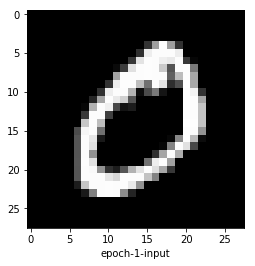

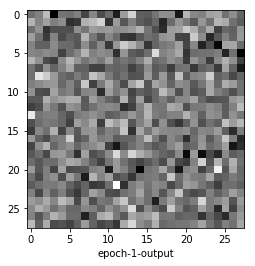

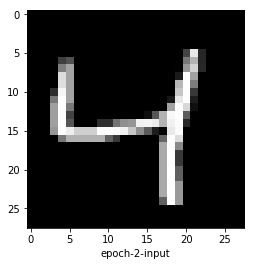

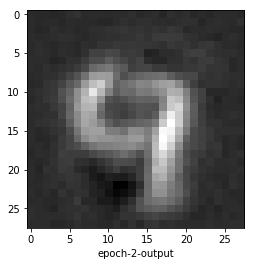

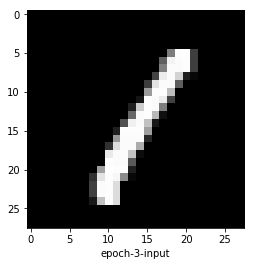

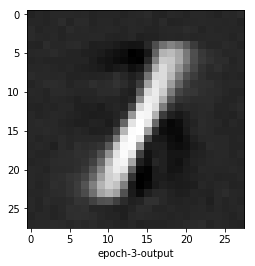

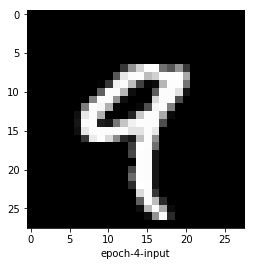

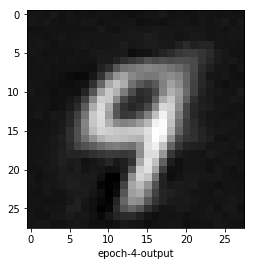

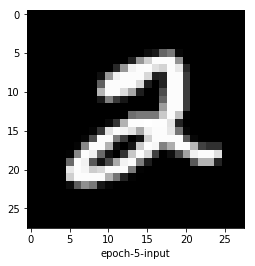

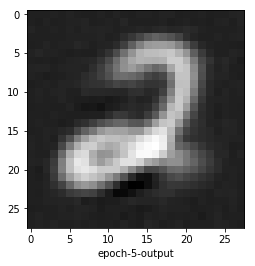

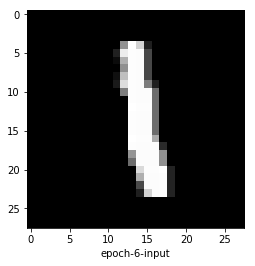

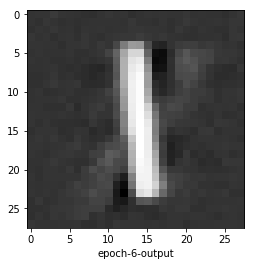

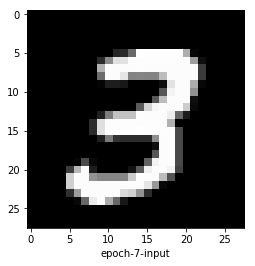

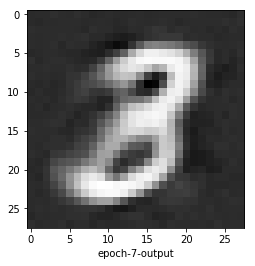

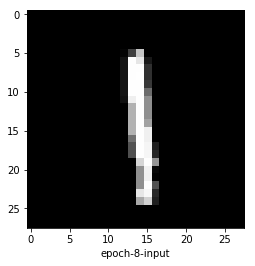

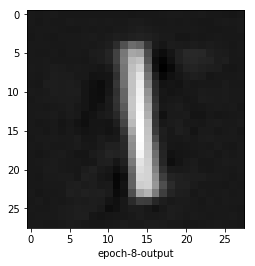

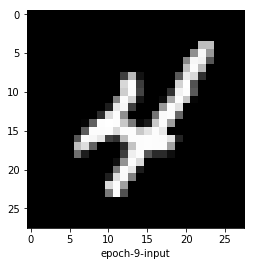

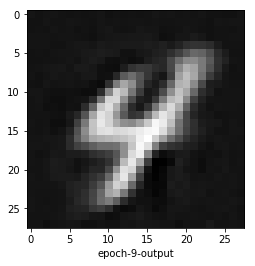

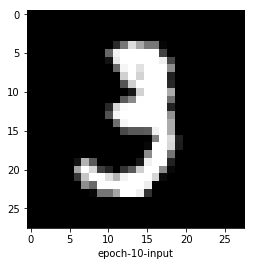

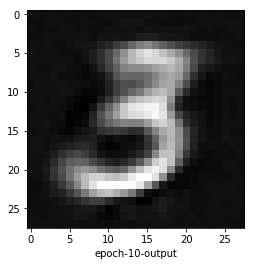

In [13]:
for epoch in 1...epochCount {
    let sampleImage = Tensor(shape: [1, imageHeight * imageWidth], scalars: dataset.trainingImages[epoch].scalars)
    let testImage = autoencoder(sampleImage)

    plot(image: sampleImage.scalars, name: "epoch-\(epoch)-input")
    plot(image: testImage.scalars, name: "epoch-\(epoch)-output")

    let sampleLoss = meanSquaredError(predicted: testImage, expected: sampleImage)
    print("[Epoch: \(epoch)] Loss: \(sampleLoss)")

    for i in 0 ..< dataset.trainingSize / batchSize {
        let x = dataset.trainingImages.minibatch(at: i, batchSize: batchSize)

        let 𝛁model = autoencoder.gradient { autoencoder -> Tensor<Float> in
            let image = autoencoder(x)
            return meanSquaredError(predicted: image, expected: x)
        }

        optimizer.update(&autoencoder.allDifferentiableVariables, along: 𝛁model)
    }
}

## Conclusion

An autoencoder is an artificial neural network used for unsupervised learning of efficient codings. In the modern era, autoencoders have become an emerging field of research in numerous aspects such as in anomaly detection. In this notebook, we intented to provide a basic understanding of the aspects of what, why and how of autoencoders.


The ideal autoencoder model balances the following:

* Sensitive to the inputs enough to accurately build a reconstruction.
* Insensitive enough to the inputs that the model doesn't simply memorize or overfit the training data.

Today, data denoising and dimensionality reduction for data visualization are considered as two main interesting practical applications of autoencoders. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.